# Import libraries

In [1]:
import os
import pandas as pd
import pickle 
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import scipy.stats as stats
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import seaborn as sns
from sklearn.utils import resample
from xgboost import XGBClassifier

# Import the dataset

In [2]:
folder_path=r"/kaggle/input/wesad-full-dataset"
print("Folder exists:", os.path.exists(folder_path))
print("Files in folder:", os.listdir(folder_path))

Folder exists: True
Files in folder: ['README.txt', 'LICENSE.txt', 'WESAD']


# Extract respiration signals

In [3]:
# Extract Subject ID, Respiration signal, and Labels; save in resp_signals dictionary
resp_signals = {}

for root, dirs, files in os.walk(folder_path):
    for filename in files:
        if filename.endswith('.pkl'):
           full_path = os.path.join(root, filename)
           with open(full_path, 'rb') as f:
               data = pickle.load(f, encoding='latin1')
               subject_id = data['subject']
               resp_signal = data['signal']['chest']['Resp']  # Extract chest resp
               label = data['label']  # Full label sequence 

               # Store Resp + label for future use in ML
               resp_signals[subject_id] = {
                    'resp': resp_signal,
                    'label': label
               }

print(f"Extracted respiration signals for {len(resp_signals)} subjects.")

Extracted respiration signals for 15 subjects.


# Filtering respiration signals 

In [4]:
# Dictionary to store filtered Respiration signals
filtered_resp_signals = {}

# Labels to remove
labels_to_remove = {0, 5, 6, 7}

# Iterate through each subject in resp_signals
for subject_id, data in resp_signals.items():
    resp_signal = np.squeeze(data['resp'])  # Remove unnecessary dimensions
    label = np.array(data['label'])         # Make sure label is a NumPy array

    # Sanity check
    unique_labels = np.unique(label)
    print(f"\nSubject {subject_id}:")
    print(f"  Unique Labels Before Filtering = {unique_labels}")
    print(f"  Total Samples Before Filtering = {len(label)}")
    print(f"  Respiration Shape = {resp_signal.shape}, Labels Shape = {label.shape}")

    # Ensure they match
    assert len(resp_signal) == len(label), f"Length mismatch for subject {subject_id}"

    # Filter out unwanted labels
    mask = ~np.isin(label, list(labels_to_remove))
    filtered_resp = resp_signal[mask]
    filtered_labels = label[mask]

    # After filtering
    unique_labels_after = np.unique(filtered_labels)
    print(f"  Unique Labels After Filtering = {unique_labels_after}")
    print(f"  Total Samples After Filtering = {len(filtered_labels)}")
    print(f"  Filtered Respiration Shape = {filtered_resp.shape}, Filtered Labels Shape = {filtered_labels.shape}")

    # Store the filtered signals
    filtered_resp_signals[subject_id] = {
        'resp': filtered_resp,
        'label': filtered_labels
    }


Subject S14:
  Unique Labels Before Filtering = [0 1 2 3 4 5 6 7]
  Total Samples Before Filtering = 3883600
  Respiration Shape = (3883600,), Labels Shape = (3883600,)
  Unique Labels After Filtering = [1 2 3 4]
  Total Samples After Filtering = 2114701
  Filtered Respiration Shape = (2114701,), Filtered Labels Shape = (2114701,)

Subject S11:
  Unique Labels Before Filtering = [0 1 2 3 4 5 6 7]
  Total Samples Before Filtering = 3663100
  Respiration Shape = (3663100,), Labels Shape = (3663100,)
  Unique Labels After Filtering = [1 2 3 4]
  Total Samples After Filtering = 2113301
  Filtered Respiration Shape = (2113301,), Filtered Labels Shape = (2113301,)

Subject S13:
  Unique Labels Before Filtering = [0 1 2 3 4 5 6 7]
  Total Samples Before Filtering = 3875900
  Respiration Shape = (3875900,), Labels Shape = (3875900,)
  Unique Labels After Filtering = [1 2 3 4]
  Total Samples After Filtering = 2114700
  Filtered Respiration Shape = (2114700,), Filtered Labels Shape = (2114700,

In [5]:
# Accumulate all labels across subjects
all_filtered_labels = []

for data in filtered_resp_signals.values():
    all_filtered_labels.extend(data['label'])  # Add all labels from this subject

# Count the total number of occurrences per label
label_counts = Counter(all_filtered_labels)

# Define label names for readability
label_names = {1: "Baseline", 2: "Stress", 3: "Amusement", 4: "Meditation"}

# Print counts
print("Total number of samples per label across all subjects:")
for label in sorted(label_counts):
    print(f"Label {label} ({label_names.get(label, 'Unknown')}): {label_counts[label]}")

Total number of samples per label across all subjects:
Label 1 (Baseline): 12327702
Label 2 (Stress): 6976201
Label 3 (Amusement): 3902501
Label 4 (Meditation): 8264199


# Visualizing the data


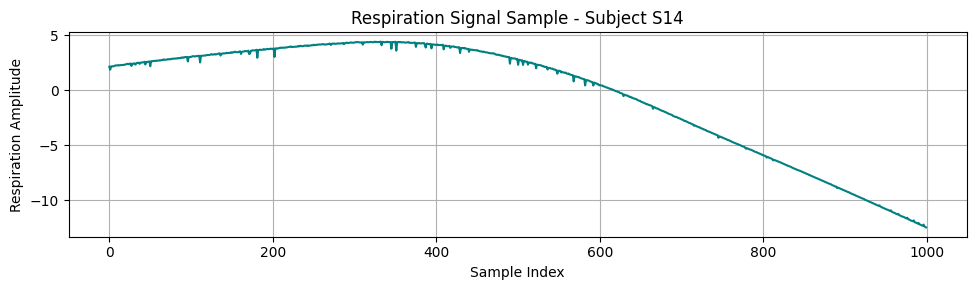

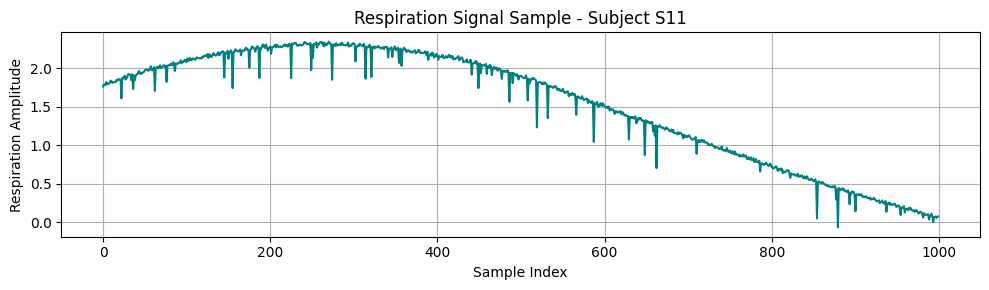

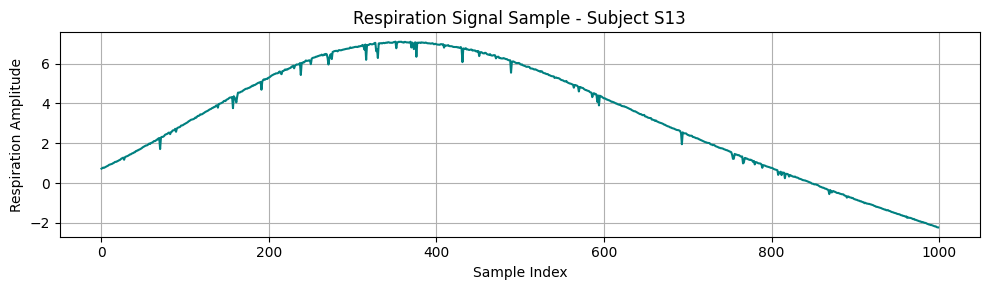

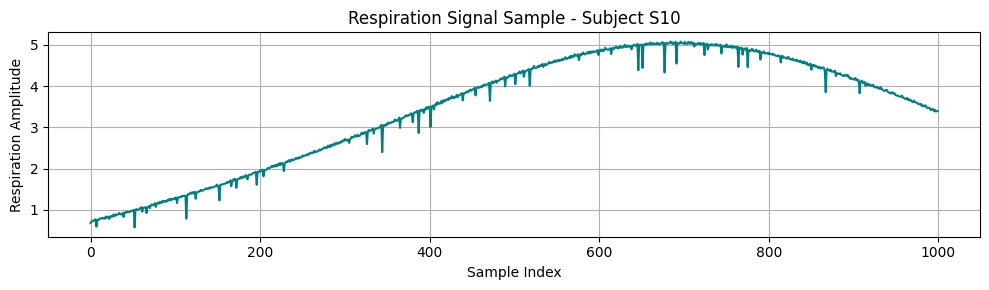

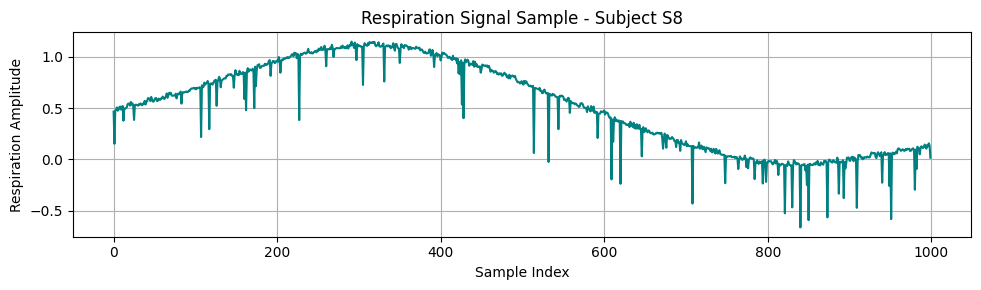

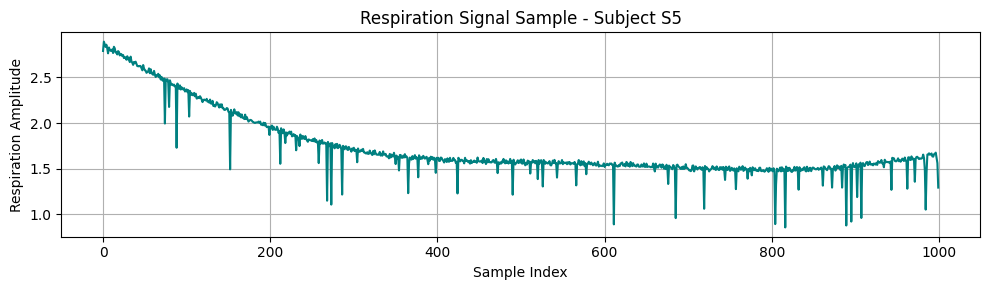

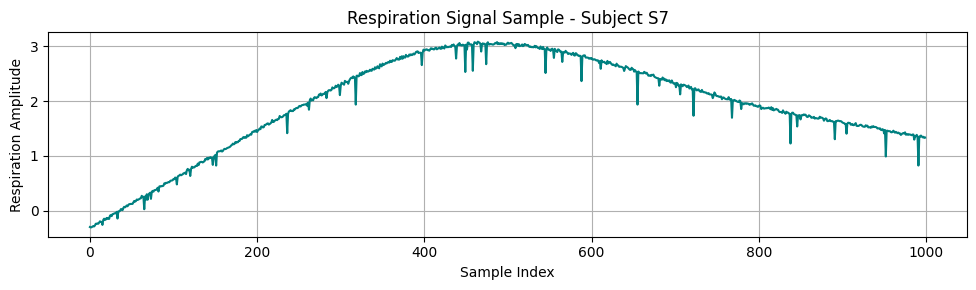

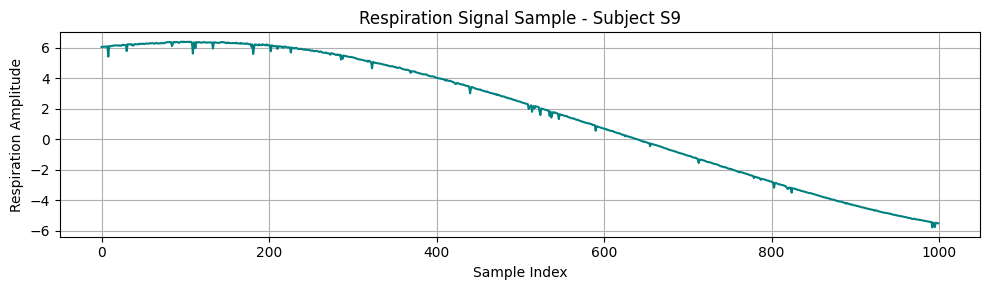

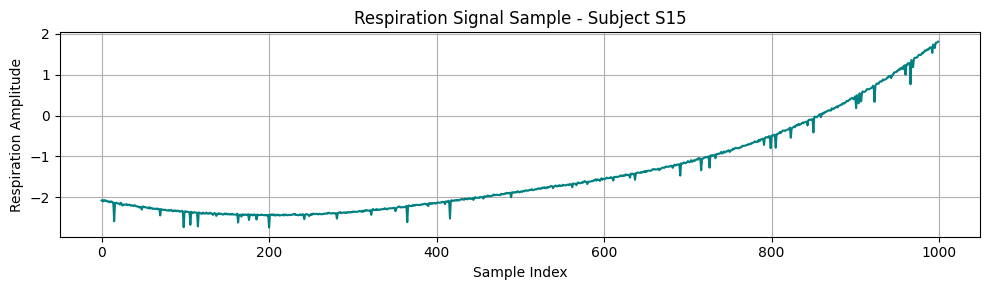

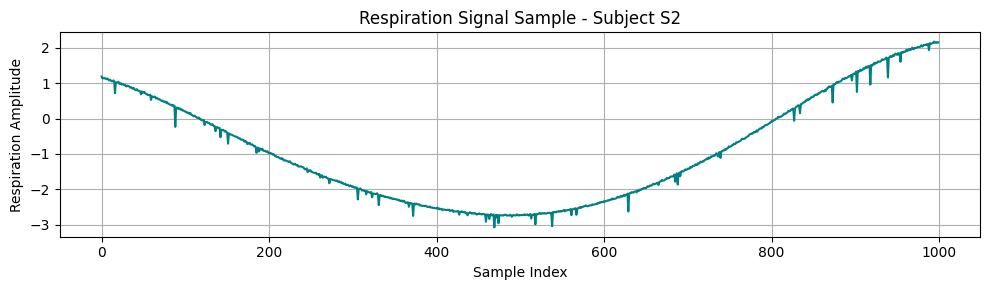

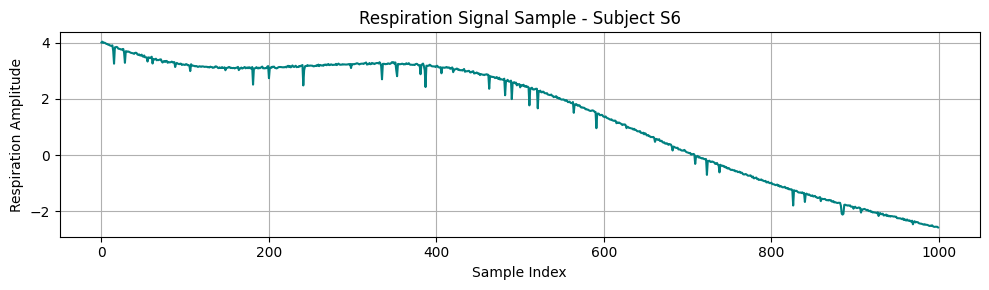

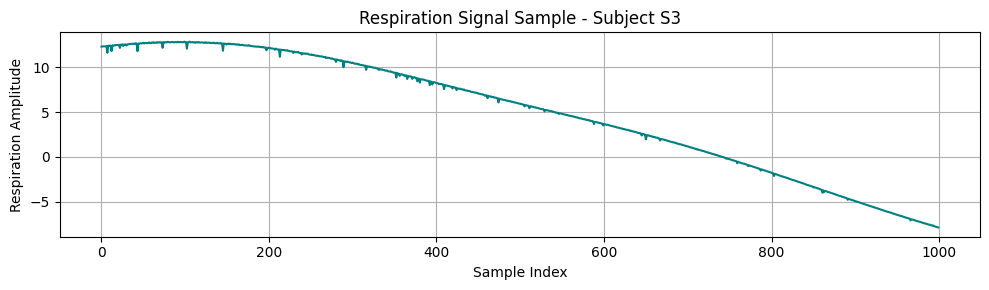

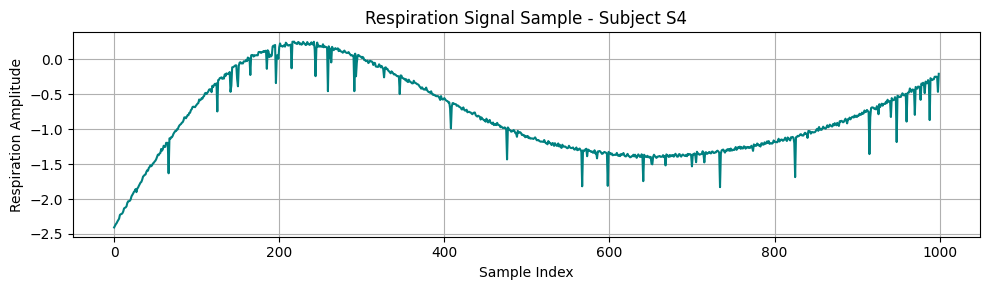

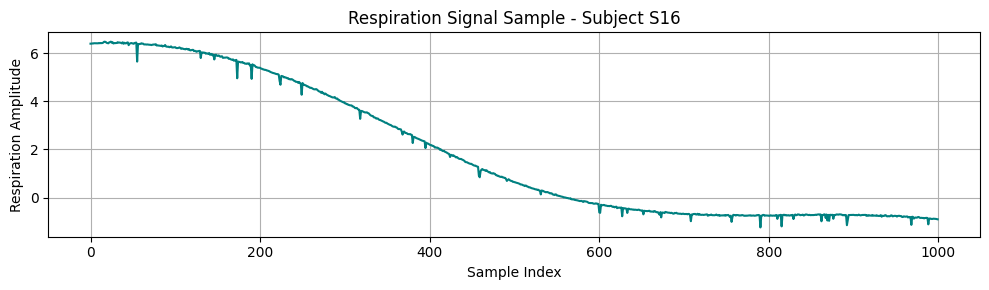

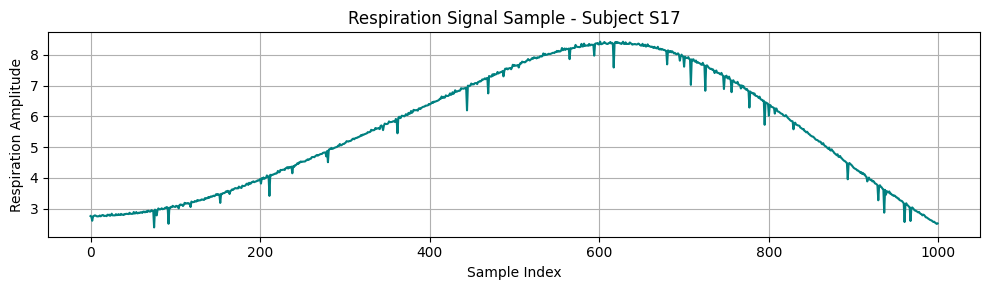

In [6]:
# Number of points to show per subject
sample_length = 1000

# Plot one respiration signal sample per subject
for subject_id, data in filtered_resp_signals.items():
    resp_signal = data['resp']
    
    # Extract a sample segment
    sample = resp_signal[:sample_length]

    # Plot
    plt.figure(figsize=(10, 3))
    plt.plot(sample, color='teal')
    plt.title(f"Respiration Signal Sample - Subject {subject_id}")
    plt.xlabel("Sample Index")
    plt.ylabel("Respiration Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


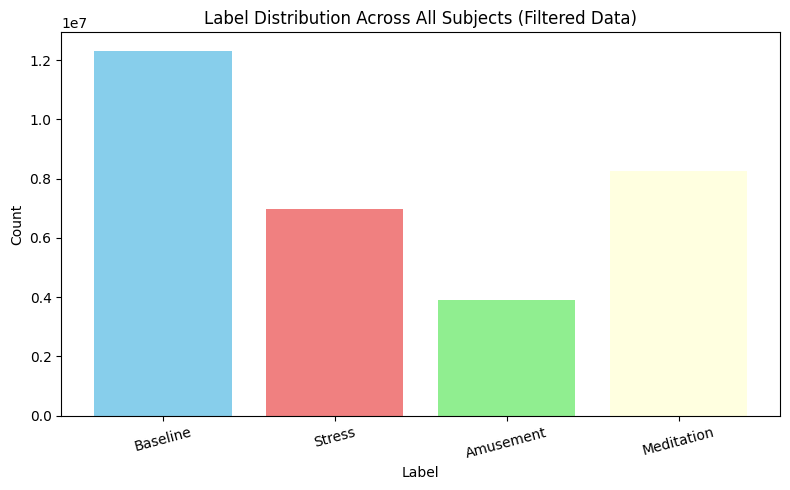

In [7]:
# List to accumulate all filtered labels from filtered_resp_signals
all_filtered_labels = []

# Define colors for each label
label_colors = {
    1: 'skyblue',        # Baseline
    2: 'lightcoral',     # Stress
    3: 'lightgreen',     # Amusement
    4: 'lightyellow'     # Meditation
}

# Define label names for clarity
label_names = {1: "Baseline", 2: "Stress", 3: "Amusement", 4: "Meditation"}

# Iterate through each subject in filtered_resp_signals
for subject_id, data in filtered_resp_signals.items():
    filtered_labels = data['label']  # Extract the filtered labels

    # Accumulate the labels for histogram plotting
    all_filtered_labels.extend(filtered_labels)

# Plot histogram of the label distribution across all subjects
plt.figure(figsize=(8, 5))

# Count the occurrences of each label
label_counts = dict(zip(*np.unique(all_filtered_labels, return_counts=True)))

# Plot bars with different colors for each label
plt.bar(
    [label_names.get(label, f"Label {label}") for label in label_counts.keys()],  # Label names on x-axis
    label_counts.values(),
    color=[label_colors.get(label, 'gray') for label in label_counts.keys()]
)

# Set title and labels
plt.title("Label Distribution Across All Subjects (Filtered Data)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=15)

# Tight layout for better formatting
plt.tight_layout()
plt.show()

Total samples across all subjects:
No Stress (0): 24494402
Stress    (1): 6976201


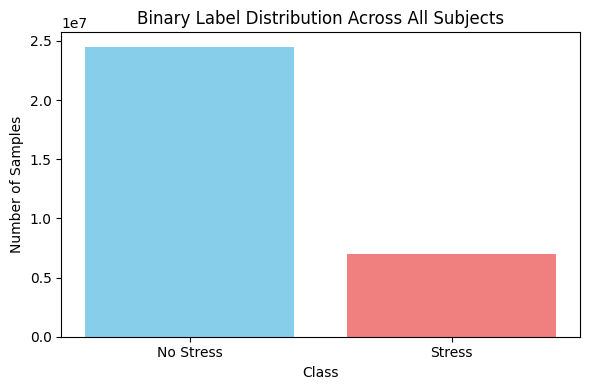

In [8]:
# Define binary mapping: 1, 3, 4 → 0 (No Stress), 2 → 1 (Stress)
def map_to_binary(labels):
    return np.where(labels == 2, 1, 0)

# Counters to accumulate total samples
binary_label_totals = Counter()

for subject_id, data in filtered_resp_signals.items():
    labels = data['label']
    
    # Map labels to binary
    binary_labels = map_to_binary(labels)

    # Count and accumulate
    binary_label_totals.update(binary_labels)

# Print the total sample count for each binary class
print("Total samples across all subjects:")
print(f"No Stress (0): {binary_label_totals[0]}")
print(f"Stress    (1): {binary_label_totals[1]}")

# Plot the histogram
plt.figure(figsize=(6, 4))
plt.bar(
    ['No Stress', 'Stress'],
    [binary_label_totals[0], binary_label_totals[1]],
    color=['skyblue', 'lightcoral']
)
plt.title('Binary Label Distribution Across All Subjects')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.show()

In [9]:
# Create the binary_resp_signals dictionary for actual segmentation use
binary_resp_signals = {}

for subject_id, data in filtered_resp_signals.items():
    resp = data['resp']
    labels = data['label']
    
    binary_labels = map_to_binary(labels)
    
    binary_resp_signals[subject_id] = {
        'resp': resp,
        'label': binary_labels
    }

# Segmentation 

In [10]:
def segment_subject_signal(resp, labels, window_size_s, shift_s, fs):
    """
    Segments respiration signal and labels into windows of specified size and shift.
    """
    window_size = window_size_s * fs  # samples per window
    shift = shift_s * fs              # samples to shift per window

    segmented_features = []
    segmented_labels = []

    for start in range(0, len(resp) - window_size + 1, shift):
        end = start + window_size
        window = resp[start:end]
        window_label = labels[start:end]

        if len(window_label) == 0:
            continue

        # Assign the majority label in the window
        majority_label = Counter(window_label).most_common(1)[0][0]

        segmented_features.append(window)
        segmented_labels.append(majority_label)

    return segmented_features, segmented_labels

In [11]:
# Sampling frequency (modify if different)
fs = 700

# Example: Segment with 60s window and 30s shift
window_size_s = 60
shift_s = 10

# Store all segmented data
segmented_data = {}

for subject_id, data in binary_resp_signals.items():
    resp = data['resp']
    labels = data['label']

    segments, segment_labels = segment_subject_signal(resp, labels, window_size_s, shift_s, fs)

    segmented_data[subject_id] = {
        'segments': segments,
        'labels': segment_labels
    }

    print(f"{subject_id}: {len(segments)} windows created.")

S14: 297 windows created.
S11: 296 windows created.
S13: 297 windows created.
S10: 302 windows created.
S8: 295 windows created.
S5: 296 windows created.
S7: 293 windows created.
S9: 294 windows created.
S15: 297 windows created.
S2: 283 windows created.
S6: 293 windows created.
S3: 288 windows created.
S4: 292 windows created.
S16: 296 windows created.
S17: 295 windows created.


# Feature extraction

In [12]:
# Feature extraction function for a single segment
def extract_features(resp_segment, fs=700):
    features = []

    # ---- Time-domain features ----
    features.append(np.mean(resp_segment))                     # Mean
    features.append(np.var(resp_segment))                      # Variance
    features.append(np.std(resp_segment))                      # Standard Deviation
    features.append(np.median(resp_segment))                   # Median
    features.append(np.max(resp_segment))                      # Maximum
    features.append(np.min(resp_segment))                      # Minimum
    features.append(np.percentile(resp_segment, 25))           # Q1
    features.append(np.percentile(resp_segment, 75))           # Q3
    features.append(stats.skew(resp_segment))                  # Skewness
    features.append(stats.kurtosis(resp_segment))              # Kurtosis

    # ---- Frequency-domain features using Power Spectral Density (PSD) ----
    freqs, psd = welch(resp_segment, fs=fs)
    features.append(np.mean(psd))                              # PSD Mean
    features.append(np.var(psd))                               # PSD Variance
    features.append(np.std(psd))                               # PSD Std
    features.append(np.median(psd))                            # PSD Median
    features.append(np.max(psd))                               # PSD Maximum
    features.append(np.min(psd))                               # PSD Minimum
    features.append(np.percentile(psd, 25))                    # PSD Q1
    features.append(np.percentile(psd, 75))                    # PSD Q3
    features.append(stats.skew(psd))                           # PSD Skewness
    features.append(stats.kurtosis(psd))                       # PSD Kurtosis

    return features

# Normalization

In [13]:
all_features = []
all_labels = []

for subject_data in segmented_data.values():
    segments = subject_data['segments']
    labels = subject_data['labels']

    for segment, label in zip(segments, labels):
        features = extract_features(segment)
        all_features.append(features)
        all_labels.append(label)


In [14]:
# Convert lists to NumPy arrays
X = np.array(all_features)  # shape: (n_samples, 20)
y = np.array(all_labels)    # shape: (n_samples,)

# Normalize features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Print shapes
print("Normalized feature matrix shape:", X_normalized.shape)
print("Label array shape:", y.shape)

Normalized feature matrix shape: (4414, 20)
Label array shape: (4414,)


# Feature selection

In [15]:
# Assuming X and y are already defined (feature matrix and labels)
# Example: Let's assume X is your feature matrix (e.g., from the previous feature extraction steps),
# and y is your label vector (e.g., binary labels 0 and 1).

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Fit a Random Forest model on the training data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 2: Use SelectFromModel to choose important features
sfm = SelectFromModel(rf, prefit=True)
X_train_selected = sfm.transform(X_train)
X_test_selected = sfm.transform(X_test)

# Get the indices of the selected features
selected_features = sfm.get_support(indices=True)

# Print original number of features and selected number of features
print(f"Original number of features: {X_train.shape[1]}")
print(f"Selected number of features: {X_train_selected.shape[1]}")

# Print the names of the selected features
# Assuming that your original features are represented as columns in a DataFrame
# If X_train is a DataFrame, you can access the columns directly.

# If X_train is a DataFrame, the feature names are in its columns
if isinstance(X_train, pd.DataFrame):
    feature_names = X_train.columns  # Get feature names from the DataFrame
else:
    # If X_train is a numpy array, generate feature names as "Feature 1", "Feature 2", ...
    feature_names = [f"Feature {i+1}" for i in range(X_train.shape[1])]

# Print selected feature names
print("\nSelected Features:")
for idx in selected_features:
    print(feature_names[idx])  # Access the feature names based on the selected indices


Original number of features: 20
Selected number of features: 7

Selected Features:
Feature 7
Feature 9
Feature 11
Feature 13
Feature 15
Feature 19
Feature 20


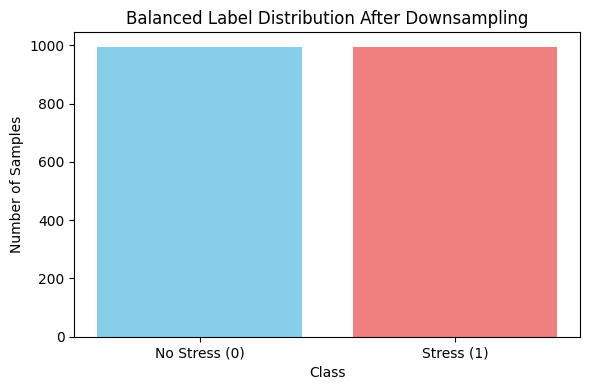

In [16]:
# Combine features and labels into a DataFrame for easier manipulation
df = pd.DataFrame(X_normalized)
df['label'] = y

# Separate majority and minority classes
majority_class = df[df['label'] == 0]  # No Stress
minority_class = df[df['label'] == 1]  # Stress

# Downsample majority class
majority_downsampled = resample(
    majority_class,
    replace=False,
    n_samples=len(minority_class),  # Match minority class size
    random_state=42
)

# Combine downsampled majority with minority
df_balanced = pd.concat([majority_downsampled, minority_class])

# Shuffle the balanced dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into features and labels again
X_balanced = df_balanced.drop(columns=['label']).values
y_balanced = df_balanced['label'].values

# --- Plot histogram of balanced label distribution ---
label_counts = df_balanced['label'].value_counts().sort_index()
plt.figure(figsize=(6, 4))
plt.bar(['No Stress (0)', 'Stress (1)'], label_counts.values, color=['skyblue', 'lightcoral'])
plt.title("Balanced Label Distribution After Downsampling")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()


# Model

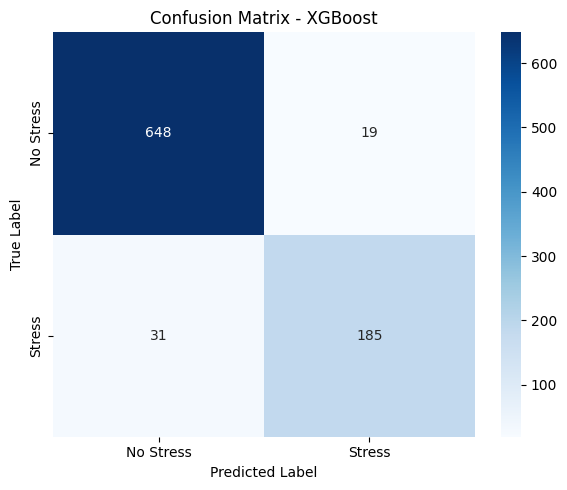


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       667
           1       0.91      0.86      0.88       216

    accuracy                           0.94       883
   macro avg       0.93      0.91      0.92       883
weighted avg       0.94      0.94      0.94       883

Accuracy: 0.9434


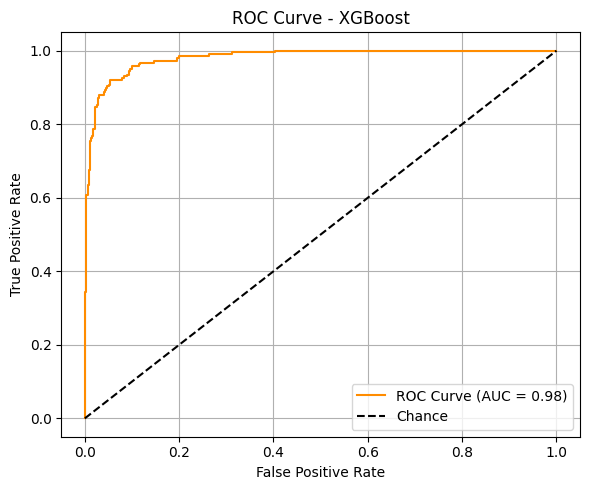

In [17]:
# Initialize and train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_selected, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test_selected)
y_proba = xgb_model.predict_proba(X_test_selected)[:, 1]  # Probability scores for ROC

# ----- Confusion Matrix -----
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Stress", "Stress"],
            yticklabels=["No Stress", "Stress"])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ----- Classification Report -----
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# ----- ROC Curve -----
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


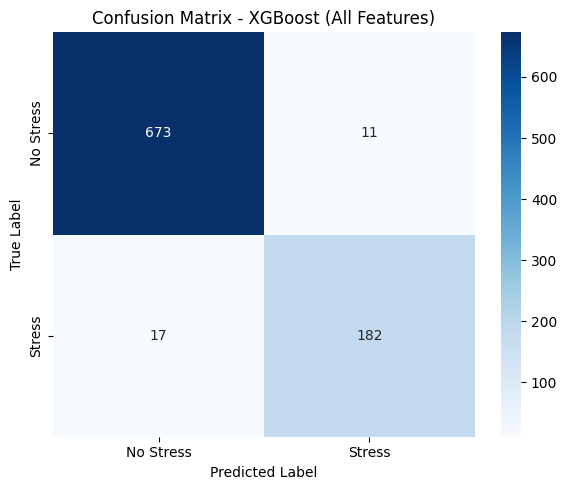


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       684
           1       0.94      0.91      0.93       199

    accuracy                           0.97       883
   macro avg       0.96      0.95      0.95       883
weighted avg       0.97      0.97      0.97       883

Accuracy: 0.9683


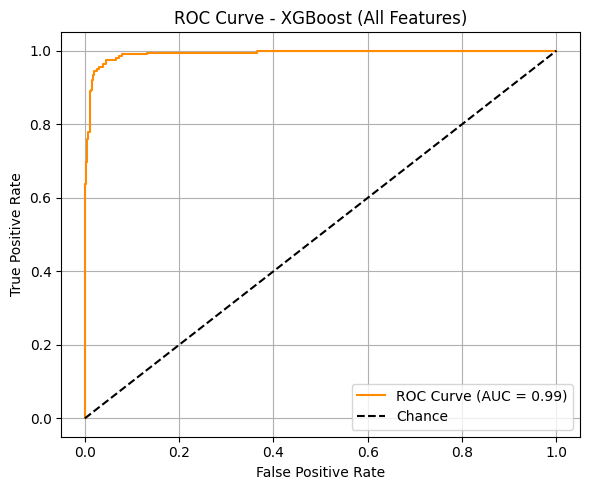

In [18]:
# Use all normalized features
X_all = X_normalized
y_all = y

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# Initialize and train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

# ----- Confusion Matrix -----
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Stress", "Stress"],
            yticklabels=["No Stress", "Stress"])
plt.title("Confusion Matrix - XGBoost (All Features)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ----- Classification Report -----
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# ----- ROC Curve -----
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost (All Features)")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
